In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer
from uncertainty_testbed.uncertainty_models.hla_dropout import HLADropout, HLALinear

2022-06-22 15:00:53.858167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 15:00:53.858192: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        layers = (
            keras.Input(shape=(eg.num_inputs,), name="input"),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
                      activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
        model = HLADropout(
            layer_tuple=layers,
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=("accuracy", "AUC"),
            name="HLADropout"
        )

        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_hla_linear_loss"]
        val_auc = history_dict["val_hla_linear_auc"]
        val_accuracy = history_dict["val_hla_linear_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            #champion_params["model"] = keras.models.clone_model(model)
        del model
        gc;
        

#model = keras.models.clone_model(champion_params["model"])

2022-06-22 15:01:02.240050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-22 15:01:02.240094: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-22 15:01:02.240127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-06-22 15:01:02.240479: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/119
130/130 [==============================] - 2s 6ms/step - loss: 0.7088 - hla_linear_loss: 0.7088 - hla_linear_accuracy: 0.4980 - hla_linear_auc: 0.4963 - val_loss: 0.6958 - val_hla_linear_loss: 0.6958 - val_hla_linear_accuracy: 0.4911 - val_hla_linear_auc: 0.4967
Epoch 2/119
130/130 [==============================] - 0s 4ms/step - loss: 0.7040 - hla_linear_loss: 0.7040 - hla_linear_accuracy: 0.5057 - hla_linear_auc: 0.5062 - val_loss: 0.6928 - val_hla_linear_loss: 0.6928 - val_hla_linear_accuracy: 0.5121 - val_hla_linear_auc: 0.5205
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.7017 - hla_linear_loss: 0.7017 - hla_linear_accuracy: 0.5093 - hla_linear_auc: 0.5130 - val_loss: 0.6899 - val_hla_linear_loss: 0.6899 - val_hla_linear_accuracy: 0.5343 - val_hla_linear_auc: 0.5446
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6976 - hla_linear_loss: 0.6976 - hla_linear_accuracy: 0.5156 - hla_linear_auc: 0.5263 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5166 - hla_linear_loss: 0.5166 - hla_linear_accuracy: 0.7464 - hla_linear_auc: 0.8312 - val_loss: 0.4201 - val_hla_linear_loss: 0.4201 - val_hla_linear_accuracy: 0.8637 - val_hla_linear_auc: 0.9475
Epoch 32/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5055 - hla_linear_loss: 0.5055 - hla_linear_accuracy: 0.7547 - hla_linear_auc: 0.8404 - val_loss: 0.4053 - val_hla_linear_loss: 0.4053 - val_hla_linear_accuracy: 0.8696 - val_hla_linear_auc: 0.9518
Epoch 33/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4944 - hla_linear_loss: 0.4944 - hla_linear_accuracy: 0.7600 - hla_linear_auc: 0.8469 - val_loss: 0.3916 - val_hla_linear_loss: 0.3916 - val_hla_linear_accuracy: 0.8760 - val_hla_linear_auc: 0.9557
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4875 - hla_linear_loss: 0.4875 - hla_linear_accuracy: 0.7629 - hla_linear_auc: 0.8513 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3428 - hla_linear_loss: 0.3428 - hla_linear_accuracy: 0.8496 - hla_linear_auc: 0.9295 - val_loss: 0.2145 - val_hla_linear_loss: 0.2145 - val_hla_linear_accuracy: 0.9448 - val_hla_linear_auc: 0.9871
Epoch 62/119
130/130 [==============================] - 0s 4ms/step - loss: 0.3411 - hla_linear_loss: 0.3411 - hla_linear_accuracy: 0.8511 - hla_linear_auc: 0.9305 - val_loss: 0.2123 - val_hla_linear_loss: 0.2123 - val_hla_linear_accuracy: 0.9447 - val_hla_linear_auc: 0.9873
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3377 - hla_linear_loss: 0.3377 - hla_linear_accuracy: 0.8520 - hla_linear_auc: 0.9314 - val_loss: 0.2100 - val_hla_linear_loss: 0.2100 - val_hla_linear_accuracy: 0.9455 - val_hla_linear_auc: 0.9875
Epoch 64/119
130/130 [==============================] - 0s 4ms/step - loss: 0.3393 - hla_linear_loss: 0.3393 - hla_linear_accuracy: 0.8522 - hla_linear_auc: 0.9311 - val_lo

Epoch 91/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2875 - hla_linear_loss: 0.2875 - hla_linear_accuracy: 0.8823 - hla_linear_auc: 0.9514 - val_loss: 0.1715 - val_hla_linear_loss: 0.1715 - val_hla_linear_accuracy: 0.9567 - val_hla_linear_auc: 0.9905
Epoch 92/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2805 - hla_linear_loss: 0.2805 - hla_linear_accuracy: 0.8822 - hla_linear_auc: 0.9533 - val_loss: 0.1700 - val_hla_linear_loss: 0.1700 - val_hla_linear_accuracy: 0.9581 - val_hla_linear_auc: 0.9907
Epoch 93/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2880 - hla_linear_loss: 0.2880 - hla_linear_accuracy: 0.8805 - hla_linear_auc: 0.9509 - val_loss: 0.1695 - val_hla_linear_loss: 0.1695 - val_hla_linear_accuracy: 0.9578 - val_hla_linear_auc: 0.9907
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2814 - hla_linear_loss: 0.2814 - hla_linear_accuracy: 0.8858 - hla_linear_auc: 0.9535 - val_lo

130/130 [==============================] - 2s 5ms/step - loss: 0.6969 - hla_linear_loss: 0.6969 - hla_linear_accuracy: 0.5137 - hla_linear_auc: 0.5160 - val_loss: 0.6856 - val_hla_linear_loss: 0.6856 - val_hla_linear_accuracy: 0.5776 - val_hla_linear_auc: 0.6090
Epoch 2/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6906 - hla_linear_loss: 0.6906 - hla_linear_accuracy: 0.5313 - hla_linear_auc: 0.5439 - val_loss: 0.6789 - val_hla_linear_loss: 0.6789 - val_hla_linear_accuracy: 0.6195 - val_hla_linear_auc: 0.6684
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6842 - hla_linear_loss: 0.6842 - hla_linear_accuracy: 0.5552 - hla_linear_auc: 0.5757 - val_loss: 0.6720 - val_hla_linear_loss: 0.6720 - val_hla_linear_accuracy: 0.6453 - val_hla_linear_auc: 0.7079
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6796 - hla_linear_loss: 0.6796 - hla_linear_accuracy: 0.5618 - hla_linear_auc: 0.5926 - val_loss: 0.6640 - val

Epoch 31/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4055 - hla_linear_loss: 0.4055 - hla_linear_accuracy: 0.8137 - hla_linear_auc: 0.8992 - val_loss: 0.2736 - val_hla_linear_loss: 0.2736 - val_hla_linear_accuracy: 0.9198 - val_hla_linear_auc: 0.9780
Epoch 32/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3968 - hla_linear_loss: 0.3968 - hla_linear_accuracy: 0.8172 - hla_linear_auc: 0.9039 - val_loss: 0.2666 - val_hla_linear_loss: 0.2666 - val_hla_linear_accuracy: 0.9218 - val_hla_linear_auc: 0.9792
Epoch 33/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3919 - hla_linear_loss: 0.3919 - hla_linear_accuracy: 0.8227 - hla_linear_auc: 0.9071 - val_loss: 0.2606 - val_hla_linear_loss: 0.2606 - val_hla_linear_accuracy: 0.9242 - val_hla_linear_auc: 0.9801
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3932 - hla_linear_loss: 0.3932 - hla_linear_accuracy: 0.8207 - hla_linear_auc: 0.9050 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3068 - hla_linear_loss: 0.3068 - hla_linear_accuracy: 0.8705 - hla_linear_auc: 0.9443 - val_loss: 0.1812 - val_hla_linear_loss: 0.1812 - val_hla_linear_accuracy: 0.9528 - val_hla_linear_auc: 0.9895
Epoch 62/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3084 - hla_linear_loss: 0.3084 - hla_linear_accuracy: 0.8687 - hla_linear_auc: 0.9435 - val_loss: 0.1801 - val_hla_linear_loss: 0.1801 - val_hla_linear_accuracy: 0.9528 - val_hla_linear_auc: 0.9895
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3029 - hla_linear_loss: 0.3029 - hla_linear_accuracy: 0.8738 - hla_linear_auc: 0.9459 - val_loss: 0.1789 - val_hla_linear_loss: 0.1789 - val_hla_linear_accuracy: 0.9535 - val_hla_linear_auc: 0.9896
Epoch 64/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3005 - hla_linear_loss: 0.3005 - hla_linear_accuracy: 0.8746 - hla_linear_auc: 0.9466 - val_lo

Epoch 91/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2573 - hla_linear_loss: 0.2573 - hla_linear_accuracy: 0.8964 - hla_linear_auc: 0.9613 - val_loss: 0.1513 - val_hla_linear_loss: 0.1513 - val_hla_linear_accuracy: 0.9628 - val_hla_linear_auc: 0.9916
Epoch 92/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2629 - hla_linear_loss: 0.2629 - hla_linear_accuracy: 0.8971 - hla_linear_auc: 0.9601 - val_loss: 0.1511 - val_hla_linear_loss: 0.1511 - val_hla_linear_accuracy: 0.9632 - val_hla_linear_auc: 0.9916
Epoch 93/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2558 - hla_linear_loss: 0.2558 - hla_linear_accuracy: 0.8978 - hla_linear_auc: 0.9620 - val_loss: 0.1501 - val_hla_linear_loss: 0.1501 - val_hla_linear_accuracy: 0.9635 - val_hla_linear_auc: 0.9917
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2531 - hla_linear_loss: 0.2531 - hla_linear_accuracy: 0.9003 - hla_linear_auc: 0.9625 - val_lo

Epoch 1/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6970 - hla_linear_loss: 0.6970 - hla_linear_accuracy: 0.5166 - hla_linear_auc: 0.5278 - val_loss: 0.6810 - val_hla_linear_loss: 0.6810 - val_hla_linear_accuracy: 0.5885 - val_hla_linear_auc: 0.6241
Epoch 2/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6860 - hla_linear_loss: 0.6860 - hla_linear_accuracy: 0.5474 - hla_linear_auc: 0.5679 - val_loss: 0.6689 - val_hla_linear_loss: 0.6689 - val_hla_linear_accuracy: 0.6433 - val_hla_linear_auc: 0.6992
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6750 - hla_linear_loss: 0.6750 - hla_linear_accuracy: 0.5769 - hla_linear_auc: 0.6093 - val_loss: 0.6548 - val_hla_linear_loss: 0.6548 - val_hla_linear_accuracy: 0.6797 - val_hla_linear_auc: 0.7475
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6663 - hla_linear_loss: 0.6663 - hla_linear_accuracy: 0.5941 - hla_linear_auc: 0.6366 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3521 - hla_linear_loss: 0.3521 - hla_linear_accuracy: 0.8425 - hla_linear_auc: 0.9251 - val_loss: 0.2158 - val_hla_linear_loss: 0.2158 - val_hla_linear_accuracy: 0.9445 - val_hla_linear_auc: 0.9869
Epoch 32/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3485 - hla_linear_loss: 0.3485 - hla_linear_accuracy: 0.8508 - hla_linear_auc: 0.9275 - val_loss: 0.2114 - val_hla_linear_loss: 0.2114 - val_hla_linear_accuracy: 0.9458 - val_hla_linear_auc: 0.9874
Epoch 33/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3431 - hla_linear_loss: 0.3431 - hla_linear_accuracy: 0.8515 - hla_linear_auc: 0.9296 - val_loss: 0.2073 - val_hla_linear_loss: 0.2073 - val_hla_linear_accuracy: 0.9474 - val_hla_linear_auc: 0.9879
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3388 - hla_linear_loss: 0.3388 - hla_linear_accuracy: 0.8533 - hla_linear_auc: 0.9315 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2653 - hla_linear_loss: 0.2653 - hla_linear_accuracy: 0.8927 - hla_linear_auc: 0.9585 - val_loss: 0.1513 - val_hla_linear_loss: 0.1513 - val_hla_linear_accuracy: 0.9644 - val_hla_linear_auc: 0.9919
Epoch 62/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2641 - hla_linear_loss: 0.2641 - hla_linear_accuracy: 0.8932 - hla_linear_auc: 0.9592 - val_loss: 0.1503 - val_hla_linear_loss: 0.1503 - val_hla_linear_accuracy: 0.9650 - val_hla_linear_auc: 0.9919
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2609 - hla_linear_loss: 0.2609 - hla_linear_accuracy: 0.8958 - hla_linear_auc: 0.9603 - val_loss: 0.1492 - val_hla_linear_loss: 0.1492 - val_hla_linear_accuracy: 0.9649 - val_hla_linear_auc: 0.9920
Epoch 64/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2609 - hla_linear_loss: 0.2609 - hla_linear_accuracy: 0.8960 - hla_linear_auc: 0.9600 - val_lo

Epoch 91/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2202 - hla_linear_loss: 0.2202 - hla_linear_accuracy: 0.9170 - hla_linear_auc: 0.9717 - val_loss: 0.1262 - val_hla_linear_loss: 0.1262 - val_hla_linear_accuracy: 0.9715 - val_hla_linear_auc: 0.9930
Epoch 92/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2157 - hla_linear_loss: 0.2157 - hla_linear_accuracy: 0.9184 - hla_linear_auc: 0.9727 - val_loss: 0.1256 - val_hla_linear_loss: 0.1256 - val_hla_linear_accuracy: 0.9719 - val_hla_linear_auc: 0.9930
Epoch 93/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2168 - hla_linear_loss: 0.2168 - hla_linear_accuracy: 0.9170 - hla_linear_auc: 0.9723 - val_loss: 0.1250 - val_hla_linear_loss: 0.1250 - val_hla_linear_accuracy: 0.9716 - val_hla_linear_auc: 0.9930
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2186 - hla_linear_loss: 0.2186 - hla_linear_accuracy: 0.9169 - hla_linear_auc: 0.9719 - val_lo

Epoch 1/249
130/130 [==============================] - 1s 4ms/step - loss: 0.7125 - hla_linear_loss: 0.7125 - hla_linear_accuracy: 0.5138 - hla_linear_auc: 0.5162 - val_loss: 0.6961 - val_hla_linear_loss: 0.6961 - val_hla_linear_accuracy: 0.5272 - val_hla_linear_auc: 0.5354
Epoch 2/249
130/130 [==============================] - 0s 3ms/step - loss: 0.7004 - hla_linear_loss: 0.7004 - hla_linear_accuracy: 0.5195 - hla_linear_auc: 0.5242 - val_loss: 0.6902 - val_hla_linear_loss: 0.6902 - val_hla_linear_accuracy: 0.5386 - val_hla_linear_auc: 0.5490
Epoch 3/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6961 - hla_linear_loss: 0.6961 - hla_linear_accuracy: 0.5203 - hla_linear_auc: 0.5292 - val_loss: 0.6875 - val_hla_linear_loss: 0.6875 - val_hla_linear_accuracy: 0.5451 - val_hla_linear_auc: 0.5621
Epoch 4/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6938 - hla_linear_loss: 0.6938 - hla_linear_accuracy: 0.5262 - hla_linear_auc: 0.5371 - val_loss: 

Epoch 31/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6368 - hla_linear_loss: 0.6368 - hla_linear_accuracy: 0.6345 - hla_linear_auc: 0.6943 - val_loss: 0.6064 - val_hla_linear_loss: 0.6064 - val_hla_linear_accuracy: 0.7207 - val_hla_linear_auc: 0.8135
Epoch 32/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6337 - hla_linear_loss: 0.6337 - hla_linear_accuracy: 0.6373 - hla_linear_auc: 0.7001 - val_loss: 0.5997 - val_hla_linear_loss: 0.5997 - val_hla_linear_accuracy: 0.7290 - val_hla_linear_auc: 0.8218
Epoch 33/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6293 - hla_linear_loss: 0.6293 - hla_linear_accuracy: 0.6450 - hla_linear_auc: 0.7075 - val_loss: 0.5924 - val_hla_linear_loss: 0.5924 - val_hla_linear_accuracy: 0.7393 - val_hla_linear_auc: 0.8300
Epoch 34/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6254 - hla_linear_loss: 0.6254 - hla_linear_accuracy: 0.6473 - hla_linear_auc: 0.7121 - val_lo

Epoch 61/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4148 - hla_linear_loss: 0.4148 - hla_linear_accuracy: 0.8103 - hla_linear_auc: 0.8958 - val_loss: 0.2799 - val_hla_linear_loss: 0.2799 - val_hla_linear_accuracy: 0.9290 - val_hla_linear_auc: 0.9825
Epoch 62/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4067 - hla_linear_loss: 0.4067 - hla_linear_accuracy: 0.8176 - hla_linear_auc: 0.9009 - val_loss: 0.2727 - val_hla_linear_loss: 0.2727 - val_hla_linear_accuracy: 0.9308 - val_hla_linear_auc: 0.9835
Epoch 63/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4024 - hla_linear_loss: 0.4024 - hla_linear_accuracy: 0.8169 - hla_linear_auc: 0.9021 - val_loss: 0.2661 - val_hla_linear_loss: 0.2661 - val_hla_linear_accuracy: 0.9337 - val_hla_linear_auc: 0.9843
Epoch 64/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3970 - hla_linear_loss: 0.3970 - hla_linear_accuracy: 0.8245 - hla_linear_auc: 0.9057 - val_lo

Epoch 91/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3011 - hla_linear_loss: 0.3011 - hla_linear_accuracy: 0.8761 - hla_linear_auc: 0.9470 - val_loss: 0.1729 - val_hla_linear_loss: 0.1729 - val_hla_linear_accuracy: 0.9601 - val_hla_linear_auc: 0.9914
Epoch 92/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3014 - hla_linear_loss: 0.3014 - hla_linear_accuracy: 0.8806 - hla_linear_auc: 0.9475 - val_loss: 0.1715 - val_hla_linear_loss: 0.1715 - val_hla_linear_accuracy: 0.9607 - val_hla_linear_auc: 0.9915
Epoch 93/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2918 - hla_linear_loss: 0.2918 - hla_linear_accuracy: 0.8854 - hla_linear_auc: 0.9510 - val_loss: 0.1697 - val_hla_linear_loss: 0.1697 - val_hla_linear_accuracy: 0.9617 - val_hla_linear_auc: 0.9915
Epoch 94/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2919 - hla_linear_loss: 0.2919 - hla_linear_accuracy: 0.8851 - hla_linear_auc: 0.9507 - val_lo

Epoch 121/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2577 - hla_linear_loss: 0.2577 - hla_linear_accuracy: 0.9007 - hla_linear_auc: 0.9614 - val_loss: 0.1462 - val_hla_linear_loss: 0.1462 - val_hla_linear_accuracy: 0.9665 - val_hla_linear_auc: 0.9924
Epoch 122/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2588 - hla_linear_loss: 0.2588 - hla_linear_accuracy: 0.9014 - hla_linear_auc: 0.9610 - val_loss: 0.1459 - val_hla_linear_loss: 0.1459 - val_hla_linear_accuracy: 0.9668 - val_hla_linear_auc: 0.9924
Epoch 123/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2530 - hla_linear_loss: 0.2530 - hla_linear_accuracy: 0.9023 - hla_linear_auc: 0.9631 - val_loss: 0.1452 - val_hla_linear_loss: 0.1452 - val_hla_linear_accuracy: 0.9665 - val_hla_linear_auc: 0.9925
Epoch 124/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2534 - hla_linear_loss: 0.2534 - hla_linear_accuracy: 0.9019 - hla_linear_auc: 0.9629 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.2294 - hla_linear_loss: 0.2294 - hla_linear_accuracy: 0.9144 - hla_linear_auc: 0.9692 - val_loss: 0.1335 - val_hla_linear_loss: 0.1335 - val_hla_linear_accuracy: 0.9684 - val_hla_linear_auc: 0.9928
Epoch 151/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2286 - hla_linear_loss: 0.2286 - hla_linear_accuracy: 0.9131 - hla_linear_auc: 0.9694 - val_loss: 0.1331 - val_hla_linear_loss: 0.1331 - val_hla_linear_accuracy: 0.9689 - val_hla_linear_auc: 0.9928
Epoch 152/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2298 - hla_linear_loss: 0.2298 - hla_linear_accuracy: 0.9148 - hla_linear_auc: 0.9692 - val_loss: 0.1328 - val_hla_linear_loss: 0.1328 - val_hla_linear_accuracy: 0.9690 - val_hla_linear_auc: 0.9929
Epoch 153/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2262 - hla_linear_loss: 0.2262 - hla_linear_accuracy: 0.9152 - hla_linear_auc: 0.9700 - val_loss: 0.1324

Epoch 180/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2116 - hla_linear_loss: 0.2116 - hla_linear_accuracy: 0.9227 - hla_linear_auc: 0.9739 - val_loss: 0.1245 - val_hla_linear_loss: 0.1245 - val_hla_linear_accuracy: 0.9716 - val_hla_linear_auc: 0.9933
Epoch 181/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2138 - hla_linear_loss: 0.2138 - hla_linear_accuracy: 0.9209 - hla_linear_auc: 0.9732 - val_loss: 0.1241 - val_hla_linear_loss: 0.1241 - val_hla_linear_accuracy: 0.9715 - val_hla_linear_auc: 0.9933
Epoch 182/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2084 - hla_linear_loss: 0.2084 - hla_linear_accuracy: 0.9216 - hla_linear_auc: 0.9744 - val_loss: 0.1238 - val_hla_linear_loss: 0.1238 - val_hla_linear_accuracy: 0.9718 - val_hla_linear_auc: 0.9934
Epoch 183/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2100 - hla_linear_loss: 0.2100 - hla_linear_accuracy: 0.9215 - hla_linear_auc: 0.9740 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.1940 - hla_linear_loss: 0.1940 - hla_linear_accuracy: 0.9277 - hla_linear_auc: 0.9776 - val_loss: 0.1183 - val_hla_linear_loss: 0.1183 - val_hla_linear_accuracy: 0.9737 - val_hla_linear_auc: 0.9937
Epoch 210/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1983 - hla_linear_loss: 0.1983 - hla_linear_accuracy: 0.9243 - hla_linear_auc: 0.9764 - val_loss: 0.1182 - val_hla_linear_loss: 0.1182 - val_hla_linear_accuracy: 0.9739 - val_hla_linear_auc: 0.9937
Epoch 211/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1969 - hla_linear_loss: 0.1969 - hla_linear_accuracy: 0.9267 - hla_linear_auc: 0.9767 - val_loss: 0.1181 - val_hla_linear_loss: 0.1181 - val_hla_linear_accuracy: 0.9739 - val_hla_linear_auc: 0.9937
Epoch 212/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1929 - hla_linear_loss: 0.1929 - hla_linear_accuracy: 0.9274 - hla_linear_auc: 0.9779 - val_loss: 0.1180

Epoch 239/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1834 - hla_linear_loss: 0.1834 - hla_linear_accuracy: 0.9303 - hla_linear_auc: 0.9799 - val_loss: 0.1148 - val_hla_linear_loss: 0.1148 - val_hla_linear_accuracy: 0.9763 - val_hla_linear_auc: 0.9940
Epoch 240/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1878 - hla_linear_loss: 0.1878 - hla_linear_accuracy: 0.9305 - hla_linear_auc: 0.9790 - val_loss: 0.1149 - val_hla_linear_loss: 0.1149 - val_hla_linear_accuracy: 0.9761 - val_hla_linear_auc: 0.9939
Epoch 241/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1882 - hla_linear_loss: 0.1882 - hla_linear_accuracy: 0.9280 - hla_linear_auc: 0.9789 - val_loss: 0.1149 - val_hla_linear_loss: 0.1149 - val_hla_linear_accuracy: 0.9758 - val_hla_linear_auc: 0.9939
Epoch 242/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1805 - hla_linear_loss: 0.1805 - hla_linear_accuracy: 0.9313 - hla_linear_auc: 0.9807 - va

Epoch 19/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6584 - hla_linear_loss: 0.6584 - hla_linear_accuracy: 0.6150 - hla_linear_auc: 0.6638 - val_loss: 0.6358 - val_hla_linear_loss: 0.6358 - val_hla_linear_accuracy: 0.7273 - val_hla_linear_auc: 0.8185
Epoch 20/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6553 - hla_linear_loss: 0.6553 - hla_linear_accuracy: 0.6189 - hla_linear_auc: 0.6713 - val_loss: 0.6298 - val_hla_linear_loss: 0.6298 - val_hla_linear_accuracy: 0.7353 - val_hla_linear_auc: 0.8284
Epoch 21/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6514 - hla_linear_loss: 0.6514 - hla_linear_accuracy: 0.6268 - hla_linear_auc: 0.6785 - val_loss: 0.6233 - val_hla_linear_loss: 0.6233 - val_hla_linear_accuracy: 0.7431 - val_hla_linear_auc: 0.8381
Epoch 22/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6461 - hla_linear_loss: 0.6461 - hla_linear_accuracy: 0.6359 - hla_linear_auc: 0.6907 - val_lo

Epoch 49/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3953 - hla_linear_loss: 0.3953 - hla_linear_accuracy: 0.8228 - hla_linear_auc: 0.9064 - val_loss: 0.2556 - val_hla_linear_loss: 0.2556 - val_hla_linear_accuracy: 0.9447 - val_hla_linear_auc: 0.9869
Epoch 50/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3900 - hla_linear_loss: 0.3900 - hla_linear_accuracy: 0.8253 - hla_linear_auc: 0.9085 - val_loss: 0.2486 - val_hla_linear_loss: 0.2486 - val_hla_linear_accuracy: 0.9462 - val_hla_linear_auc: 0.9874
Epoch 51/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3804 - hla_linear_loss: 0.3804 - hla_linear_accuracy: 0.8320 - hla_linear_auc: 0.9141 - val_loss: 0.2422 - val_hla_linear_loss: 0.2422 - val_hla_linear_accuracy: 0.9469 - val_hla_linear_auc: 0.9879
Epoch 52/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3786 - hla_linear_loss: 0.3786 - hla_linear_accuracy: 0.8330 - hla_linear_auc: 0.9147 - val_lo

Epoch 79/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2927 - hla_linear_loss: 0.2927 - hla_linear_accuracy: 0.8814 - hla_linear_auc: 0.9502 - val_loss: 0.1659 - val_hla_linear_loss: 0.1659 - val_hla_linear_accuracy: 0.9640 - val_hla_linear_auc: 0.9919
Epoch 80/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2922 - hla_linear_loss: 0.2922 - hla_linear_accuracy: 0.8841 - hla_linear_auc: 0.9503 - val_loss: 0.1647 - val_hla_linear_loss: 0.1647 - val_hla_linear_accuracy: 0.9639 - val_hla_linear_auc: 0.9919
Epoch 81/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2868 - hla_linear_loss: 0.2868 - hla_linear_accuracy: 0.8868 - hla_linear_auc: 0.9522 - val_loss: 0.1633 - val_hla_linear_loss: 0.1633 - val_hla_linear_accuracy: 0.9647 - val_hla_linear_auc: 0.9920
Epoch 82/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2878 - hla_linear_loss: 0.2878 - hla_linear_accuracy: 0.8837 - hla_linear_auc: 0.9519 - val_lo

Epoch 109/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2488 - hla_linear_loss: 0.2488 - hla_linear_accuracy: 0.9056 - hla_linear_auc: 0.9639 - val_loss: 0.1414 - val_hla_linear_loss: 0.1414 - val_hla_linear_accuracy: 0.9688 - val_hla_linear_auc: 0.9927
Epoch 110/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2479 - hla_linear_loss: 0.2479 - hla_linear_accuracy: 0.9049 - hla_linear_auc: 0.9640 - val_loss: 0.1409 - val_hla_linear_loss: 0.1409 - val_hla_linear_accuracy: 0.9689 - val_hla_linear_auc: 0.9927
Epoch 111/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2499 - hla_linear_loss: 0.2499 - hla_linear_accuracy: 0.9034 - hla_linear_auc: 0.9638 - val_loss: 0.1407 - val_hla_linear_loss: 0.1407 - val_hla_linear_accuracy: 0.9689 - val_hla_linear_auc: 0.9926
Epoch 112/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2462 - hla_linear_loss: 0.2462 - hla_linear_accuracy: 0.9070 - hla_linear_auc: 0.9647 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.2216 - hla_linear_loss: 0.2216 - hla_linear_accuracy: 0.9167 - hla_linear_auc: 0.9712 - val_loss: 0.1289 - val_hla_linear_loss: 0.1289 - val_hla_linear_accuracy: 0.9714 - val_hla_linear_auc: 0.9931
Epoch 139/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2247 - hla_linear_loss: 0.2247 - hla_linear_accuracy: 0.9139 - hla_linear_auc: 0.9704 - val_loss: 0.1285 - val_hla_linear_loss: 0.1285 - val_hla_linear_accuracy: 0.9716 - val_hla_linear_auc: 0.9932
Epoch 140/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2208 - hla_linear_loss: 0.2208 - hla_linear_accuracy: 0.9187 - hla_linear_auc: 0.9716 - val_loss: 0.1281 - val_hla_linear_loss: 0.1281 - val_hla_linear_accuracy: 0.9715 - val_hla_linear_auc: 0.9932
Epoch 141/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2192 - hla_linear_loss: 0.2192 - hla_linear_accuracy: 0.9170 - hla_linear_auc: 0.9718 - val_loss: 0.1277

Epoch 168/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2028 - hla_linear_loss: 0.2028 - hla_linear_accuracy: 0.9244 - hla_linear_auc: 0.9759 - val_loss: 0.1195 - val_hla_linear_loss: 0.1195 - val_hla_linear_accuracy: 0.9738 - val_hla_linear_auc: 0.9936
Epoch 169/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1980 - hla_linear_loss: 0.1980 - hla_linear_accuracy: 0.9261 - hla_linear_auc: 0.9769 - val_loss: 0.1192 - val_hla_linear_loss: 0.1192 - val_hla_linear_accuracy: 0.9741 - val_hla_linear_auc: 0.9936
Epoch 170/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1994 - hla_linear_loss: 0.1994 - hla_linear_accuracy: 0.9261 - hla_linear_auc: 0.9767 - val_loss: 0.1189 - val_hla_linear_loss: 0.1189 - val_hla_linear_accuracy: 0.9743 - val_hla_linear_auc: 0.9936
Epoch 171/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1980 - hla_linear_loss: 0.1980 - hla_linear_accuracy: 0.9261 - hla_linear_auc: 0.9769 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.1835 - hla_linear_loss: 0.1835 - hla_linear_accuracy: 0.9327 - hla_linear_auc: 0.9801 - val_loss: 0.1116 - val_hla_linear_loss: 0.1116 - val_hla_linear_accuracy: 0.9761 - val_hla_linear_auc: 0.9940
Epoch 198/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1849 - hla_linear_loss: 0.1849 - hla_linear_accuracy: 0.9327 - hla_linear_auc: 0.9797 - val_loss: 0.1114 - val_hla_linear_loss: 0.1114 - val_hla_linear_accuracy: 0.9761 - val_hla_linear_auc: 0.9940
Epoch 199/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1874 - hla_linear_loss: 0.1874 - hla_linear_accuracy: 0.9285 - hla_linear_auc: 0.9789 - val_loss: 0.1114 - val_hla_linear_loss: 0.1114 - val_hla_linear_accuracy: 0.9761 - val_hla_linear_auc: 0.9940
Epoch 200/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1812 - hla_linear_loss: 0.1812 - hla_linear_accuracy: 0.9320 - hla_linear_auc: 0.9806 - val_loss: 0.1111

Epoch 227/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1746 - hla_linear_loss: 0.1746 - hla_linear_accuracy: 0.9358 - hla_linear_auc: 0.9816 - val_loss: 0.1056 - val_hla_linear_loss: 0.1056 - val_hla_linear_accuracy: 0.9785 - val_hla_linear_auc: 0.9943
Epoch 228/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1697 - hla_linear_loss: 0.1697 - hla_linear_accuracy: 0.9366 - hla_linear_auc: 0.9827 - val_loss: 0.1054 - val_hla_linear_loss: 0.1054 - val_hla_linear_accuracy: 0.9785 - val_hla_linear_auc: 0.9943
Epoch 229/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1709 - hla_linear_loss: 0.1709 - hla_linear_accuracy: 0.9373 - hla_linear_auc: 0.9825 - val_loss: 0.1050 - val_hla_linear_loss: 0.1050 - val_hla_linear_accuracy: 0.9787 - val_hla_linear_auc: 0.9943
Epoch 230/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1692 - hla_linear_loss: 0.1692 - hla_linear_accuracy: 0.9355 - hla_linear_auc: 0.9829 - va

Epoch 7/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6821 - hla_linear_loss: 0.6821 - hla_linear_accuracy: 0.5601 - hla_linear_auc: 0.5837 - val_loss: 0.6650 - val_hla_linear_loss: 0.6650 - val_hla_linear_accuracy: 0.6485 - val_hla_linear_auc: 0.7223
Epoch 8/249
130/130 [==============================] - 0s 4ms/step - loss: 0.6782 - hla_linear_loss: 0.6782 - hla_linear_accuracy: 0.5680 - hla_linear_auc: 0.5979 - val_loss: 0.6602 - val_hla_linear_loss: 0.6602 - val_hla_linear_accuracy: 0.6694 - val_hla_linear_auc: 0.7442
Epoch 9/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6745 - hla_linear_loss: 0.6745 - hla_linear_accuracy: 0.5791 - hla_linear_auc: 0.6108 - val_loss: 0.6549 - val_hla_linear_loss: 0.6549 - val_hla_linear_accuracy: 0.6847 - val_hla_linear_auc: 0.7651
Epoch 10/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6703 - hla_linear_loss: 0.6703 - hla_linear_accuracy: 0.5862 - hla_linear_auc: 0.6249 - val_loss:

Epoch 37/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4172 - hla_linear_loss: 0.4172 - hla_linear_accuracy: 0.8080 - hla_linear_auc: 0.8947 - val_loss: 0.2805 - val_hla_linear_loss: 0.2805 - val_hla_linear_accuracy: 0.9337 - val_hla_linear_auc: 0.9836
Epoch 38/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4107 - hla_linear_loss: 0.4107 - hla_linear_accuracy: 0.8146 - hla_linear_auc: 0.8991 - val_loss: 0.2717 - val_hla_linear_loss: 0.2717 - val_hla_linear_accuracy: 0.9363 - val_hla_linear_auc: 0.9845
Epoch 39/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4088 - hla_linear_loss: 0.4088 - hla_linear_accuracy: 0.8134 - hla_linear_auc: 0.8988 - val_loss: 0.2641 - val_hla_linear_loss: 0.2641 - val_hla_linear_accuracy: 0.9376 - val_hla_linear_auc: 0.9850
Epoch 40/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3970 - hla_linear_loss: 0.3970 - hla_linear_accuracy: 0.8206 - hla_linear_auc: 0.9047 - val_lo

Epoch 67/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2801 - hla_linear_loss: 0.2801 - hla_linear_accuracy: 0.8910 - hla_linear_auc: 0.9550 - val_loss: 0.1607 - val_hla_linear_loss: 0.1607 - val_hla_linear_accuracy: 0.9653 - val_hla_linear_auc: 0.9919
Epoch 68/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2772 - hla_linear_loss: 0.2772 - hla_linear_accuracy: 0.8919 - hla_linear_auc: 0.9557 - val_loss: 0.1592 - val_hla_linear_loss: 0.1592 - val_hla_linear_accuracy: 0.9655 - val_hla_linear_auc: 0.9919
Epoch 69/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2765 - hla_linear_loss: 0.2765 - hla_linear_accuracy: 0.8911 - hla_linear_auc: 0.9561 - val_loss: 0.1573 - val_hla_linear_loss: 0.1573 - val_hla_linear_accuracy: 0.9661 - val_hla_linear_auc: 0.9921
Epoch 70/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2736 - hla_linear_loss: 0.2736 - hla_linear_accuracy: 0.8918 - hla_linear_auc: 0.9570 - val_lo

Epoch 97/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2276 - hla_linear_loss: 0.2276 - hla_linear_accuracy: 0.9150 - hla_linear_auc: 0.9702 - val_loss: 0.1274 - val_hla_linear_loss: 0.1274 - val_hla_linear_accuracy: 0.9748 - val_hla_linear_auc: 0.9933
Epoch 98/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2182 - hla_linear_loss: 0.2182 - hla_linear_accuracy: 0.9210 - hla_linear_auc: 0.9724 - val_loss: 0.1264 - val_hla_linear_loss: 0.1264 - val_hla_linear_accuracy: 0.9753 - val_hla_linear_auc: 0.9933
Epoch 99/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2222 - hla_linear_loss: 0.2222 - hla_linear_accuracy: 0.9211 - hla_linear_auc: 0.9715 - val_loss: 0.1258 - val_hla_linear_loss: 0.1258 - val_hla_linear_accuracy: 0.9758 - val_hla_linear_auc: 0.9933
Epoch 100/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2200 - hla_linear_loss: 0.2200 - hla_linear_accuracy: 0.9191 - hla_linear_auc: 0.9720 - val_l

Epoch 127/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1912 - hla_linear_loss: 0.1912 - hla_linear_accuracy: 0.9328 - hla_linear_auc: 0.9786 - val_loss: 0.1101 - val_hla_linear_loss: 0.1101 - val_hla_linear_accuracy: 0.9793 - val_hla_linear_auc: 0.9936
Epoch 128/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1833 - hla_linear_loss: 0.1833 - hla_linear_accuracy: 0.9377 - hla_linear_auc: 0.9802 - val_loss: 0.1095 - val_hla_linear_loss: 0.1095 - val_hla_linear_accuracy: 0.9793 - val_hla_linear_auc: 0.9937
Epoch 129/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1853 - hla_linear_loss: 0.1853 - hla_linear_accuracy: 0.9354 - hla_linear_auc: 0.9796 - val_loss: 0.1090 - val_hla_linear_loss: 0.1090 - val_hla_linear_accuracy: 0.9794 - val_hla_linear_auc: 0.9937
Epoch 130/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1838 - hla_linear_loss: 0.1838 - hla_linear_accuracy: 0.9358 - hla_linear_auc: 0.9803 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.1649 - hla_linear_loss: 0.1649 - hla_linear_accuracy: 0.9447 - hla_linear_auc: 0.9837 - val_loss: 0.0987 - val_hla_linear_loss: 0.0987 - val_hla_linear_accuracy: 0.9818 - val_hla_linear_auc: 0.9940
Epoch 157/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1615 - hla_linear_loss: 0.1615 - hla_linear_accuracy: 0.9462 - hla_linear_auc: 0.9844 - val_loss: 0.0984 - val_hla_linear_loss: 0.0984 - val_hla_linear_accuracy: 0.9818 - val_hla_linear_auc: 0.9940
Epoch 158/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1637 - hla_linear_loss: 0.1637 - hla_linear_accuracy: 0.9431 - hla_linear_auc: 0.9838 - val_loss: 0.0983 - val_hla_linear_loss: 0.0983 - val_hla_linear_accuracy: 0.9812 - val_hla_linear_auc: 0.9940
Epoch 159/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1607 - hla_linear_loss: 0.1607 - hla_linear_accuracy: 0.9455 - hla_linear_auc: 0.9844 - val_loss: 0.0979

Epoch 186/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1453 - hla_linear_loss: 0.1453 - hla_linear_accuracy: 0.9511 - hla_linear_auc: 0.9868 - val_loss: 0.0912 - val_hla_linear_loss: 0.0912 - val_hla_linear_accuracy: 0.9836 - val_hla_linear_auc: 0.9942
Epoch 187/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1441 - hla_linear_loss: 0.1441 - hla_linear_accuracy: 0.9512 - hla_linear_auc: 0.9873 - val_loss: 0.0909 - val_hla_linear_loss: 0.0909 - val_hla_linear_accuracy: 0.9841 - val_hla_linear_auc: 0.9942
Epoch 188/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1450 - hla_linear_loss: 0.1450 - hla_linear_accuracy: 0.9504 - hla_linear_auc: 0.9871 - val_loss: 0.0908 - val_hla_linear_loss: 0.0908 - val_hla_linear_accuracy: 0.9841 - val_hla_linear_auc: 0.9941
Epoch 189/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1465 - hla_linear_loss: 0.1465 - hla_linear_accuracy: 0.9513 - hla_linear_auc: 0.9866 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.1317 - hla_linear_loss: 0.1317 - hla_linear_accuracy: 0.9564 - hla_linear_auc: 0.9891 - val_loss: 0.0857 - val_hla_linear_loss: 0.0857 - val_hla_linear_accuracy: 0.9840 - val_hla_linear_auc: 0.9942
Epoch 216/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1378 - hla_linear_loss: 0.1378 - hla_linear_accuracy: 0.9528 - hla_linear_auc: 0.9880 - val_loss: 0.0856 - val_hla_linear_loss: 0.0856 - val_hla_linear_accuracy: 0.9849 - val_hla_linear_auc: 0.9942
Epoch 217/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1335 - hla_linear_loss: 0.1335 - hla_linear_accuracy: 0.9556 - hla_linear_auc: 0.9886 - val_loss: 0.0855 - val_hla_linear_loss: 0.0855 - val_hla_linear_accuracy: 0.9843 - val_hla_linear_auc: 0.9943
Epoch 218/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1342 - hla_linear_loss: 0.1342 - hla_linear_accuracy: 0.9548 - hla_linear_auc: 0.9884 - val_loss: 0.0853

Epoch 245/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1250 - hla_linear_loss: 0.1250 - hla_linear_accuracy: 0.9590 - hla_linear_auc: 0.9901 - val_loss: 0.0812 - val_hla_linear_loss: 0.0812 - val_hla_linear_accuracy: 0.9846 - val_hla_linear_auc: 0.9944
Epoch 246/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1250 - hla_linear_loss: 0.1250 - hla_linear_accuracy: 0.9586 - hla_linear_auc: 0.9900 - val_loss: 0.0812 - val_hla_linear_loss: 0.0812 - val_hla_linear_accuracy: 0.9848 - val_hla_linear_auc: 0.9943
Epoch 247/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1249 - hla_linear_loss: 0.1249 - hla_linear_accuracy: 0.9592 - hla_linear_auc: 0.9898 - val_loss: 0.0809 - val_hla_linear_loss: 0.0809 - val_hla_linear_accuracy: 0.9853 - val_hla_linear_auc: 0.9944
Epoch 248/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1219 - hla_linear_loss: 0.1219 - hla_linear_accuracy: 0.9596 - hla_linear_auc: 0.9902 - va

4160/4160 [==============================] - 8s 2ms/step - loss: 0.1804 - hla_linear_loss: 0.1804 - hla_linear_accuracy: 0.9514 - hla_linear_auc: 0.9831 - val_loss: 0.2011 - val_hla_linear_loss: 0.2011 - val_hla_linear_accuracy: 0.9635 - val_hla_linear_auc: 0.9881
Epoch 5/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.1787 - hla_linear_loss: 0.1787 - hla_linear_accuracy: 0.9538 - hla_linear_auc: 0.9826 - val_loss: 0.2083 - val_hla_linear_loss: 0.2083 - val_hla_linear_accuracy: 0.9638 - val_hla_linear_auc: 0.9863
Epoch 6/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.1808 - hla_linear_loss: 0.1808 - hla_linear_accuracy: 0.9544 - hla_linear_auc: 0.9837 - val_loss: 0.2892 - val_hla_linear_loss: 0.2892 - val_hla_linear_accuracy: 0.9681 - val_hla_linear_auc: 0.9853
{'learning_rate': 0.004, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.14847175776958466, 'epoch': 2}, 'best_auc': {'auc': 0.9901497960090637, 'epoch': 2}, 'be

4160/4160 [==============================] - 8s 2ms/step - loss: 0.1195 - hla_linear_loss: 0.1195 - hla_linear_accuracy: 0.9599 - hla_linear_auc: 0.9896 - val_loss: 0.1213 - val_hla_linear_loss: 0.1213 - val_hla_linear_accuracy: 0.9736 - val_hla_linear_auc: 0.9921
{'learning_rate': 0.003, 'batch': 8, 'epoch': 3, 'optimizer': 'adam', 'best_loss': {'loss': 0.11968150734901428, 'epoch': 2}, 'best_auc': {'auc': 0.9923968315124512, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.9739000201225281, 'epoch': 5}}
Epoch 1/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.2377 - hla_linear_loss: 0.2377 - hla_linear_accuracy: 0.9008 - hla_linear_auc: 0.9666 - val_loss: 0.1529 - val_hla_linear_loss: 0.1529 - val_hla_linear_accuracy: 0.9492 - val_hla_linear_auc: 0.9886
Epoch 2/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.1783 - hla_linear_loss: 0.1783 - hla_linear_accuracy: 0.9317 - hla_linear_auc: 0.9808 - val_loss: 0.1368 - val_hla_linear_loss: 0.1368 - val_

4160/4160 [==============================] - 10s 2ms/step - loss: 0.6437 - hla_linear_loss: 0.6437 - hla_linear_accuracy: 0.6136 - hla_linear_auc: 0.6706 - val_loss: 0.4603 - val_hla_linear_loss: 0.4603 - val_hla_linear_accuracy: 0.8414 - val_hla_linear_auc: 0.9330
Epoch 2/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.4541 - hla_linear_loss: 0.4541 - hla_linear_accuracy: 0.7810 - hla_linear_auc: 0.8699 - val_loss: 0.2550 - val_hla_linear_loss: 0.2550 - val_hla_linear_accuracy: 0.9301 - val_hla_linear_auc: 0.9822
Epoch 3/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3568 - hla_linear_loss: 0.3568 - hla_linear_accuracy: 0.8396 - hla_linear_auc: 0.9224 - val_loss: 0.1934 - val_hla_linear_loss: 0.1934 - val_hla_linear_accuracy: 0.9501 - val_hla_linear_auc: 0.9884
Epoch 4/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3204 - hla_linear_loss: 0.3204 - hla_linear_accuracy: 0.8644 - hla_linear_auc: 0.9388 - val_loss: 0.1717

4160/4160 [==============================] - 8s 2ms/step - loss: 0.0886 - hla_linear_loss: 0.0886 - hla_linear_accuracy: 0.9706 - hla_linear_auc: 0.9935 - val_loss: 0.0727 - val_hla_linear_loss: 0.0727 - val_hla_linear_accuracy: 0.9789 - val_hla_linear_auc: 0.9946
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 3, 'optimizer': 'adamax', 'best_loss': {'loss': 0.07042812556028366, 'epoch': 5}, 'best_auc': {'auc': 0.9950243234634399, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.9788500070571899, 'epoch': 6}}
Epoch 1/18
4160/4160 [==============================] - 10s 2ms/step - loss: 0.2334 - hla_linear_loss: 0.2334 - hla_linear_accuracy: 0.9041 - hla_linear_auc: 0.9679 - val_loss: 0.1957 - val_hla_linear_loss: 0.1957 - val_hla_linear_accuracy: 0.9445 - val_hla_linear_auc: 0.9867
Epoch 2/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.1681 - hla_linear_loss: 0.1681 - hla_linear_accuracy: 0.9384 - hla_linear_auc: 0.9823 - val_loss: 0.2818 - val_hla_linear_loss: 0.2818 

Epoch 10/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.2810 - hla_linear_loss: 0.2810 - hla_linear_accuracy: 0.9118 - hla_linear_auc: 0.9676 - val_loss: 57.0396 - val_hla_linear_loss: 57.0396 - val_hla_linear_accuracy: 0.9352 - val_hla_linear_auc: 0.9360
Epoch 11/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3004 - hla_linear_loss: 0.3004 - hla_linear_accuracy: 0.9112 - hla_linear_auc: 0.9656 - val_loss: 78.0682 - val_hla_linear_loss: 78.0682 - val_hla_linear_accuracy: 0.9384 - val_hla_linear_auc: 0.9393
Epoch 12/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.2990 - hla_linear_loss: 0.2990 - hla_linear_accuracy: 0.9059 - hla_linear_auc: 0.9650 - val_loss: 124.3376 - val_hla_linear_loss: 124.3376 - val_hla_linear_accuracy: 0.9312 - val_hla_linear_auc: 0.9321
Epoch 13/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.2935 - hla_linear_loss: 0.2935 - hla_linear_accuracy: 0.9067 - hla_linear_auc: 0.9

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
layers = (
    keras.Input(shape=(eg.num_inputs,), name="input"),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
              activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
model = HLADropout(
    layer_tuple=layers,
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="HLADropout"
)

history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.2867 - hla_linear_loss: 0.2867 - hla_linear_accuracy: 0.8753 - hla_linear_auc: 0.9511 - val_loss: 0.1202 - val_hla_linear_loss: 0.1202 - val_hla_linear_accuracy: 0.9639 - val_hla_linear_auc: 0.9920
Epoch 2/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.1543 - hla_linear_loss: 0.1543 - hla_linear_accuracy: 0.9421 - hla_linear_auc: 0.9852 - val_loss: 0.0893 - val_hla_linear_loss: 0.0893 - val_hla_linear_accuracy: 0.9747 - val_hla_linear_auc: 0.9938
Epoch 3/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.1210 - hla_linear_loss: 0.1210 - hla_linear_accuracy: 0.9557 - hla_linear_auc: 0.9903 - val_loss: 0.0909 - val_hla_linear_loss: 0.0909 - val_hla_linear_accuracy: 0.9683 - val_hla_linear_auc: 0.9937
Epoch 4/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.1016 - hla_linear_loss: 0.1016 - hla_linear_accuracy: 0.9644 - hla_linear_auc: 0.9925 - val_loss: 

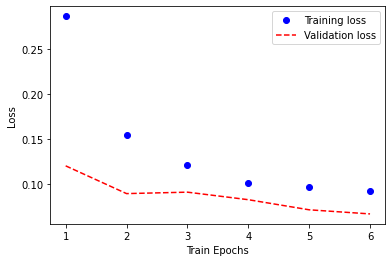

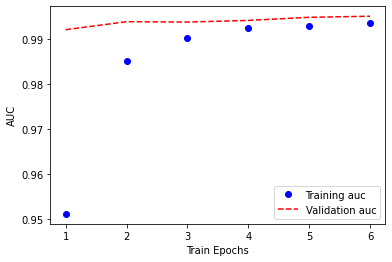

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["hla_linear_loss"]
val_loss = history_dict["val_hla_linear_loss"]
auc = history_dict["hla_linear_auc"]
val_auc = history_dict["val_hla_linear_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

#p = model.model(x_val[:1000,:])[0][:]
p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

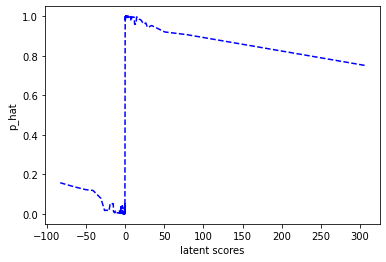

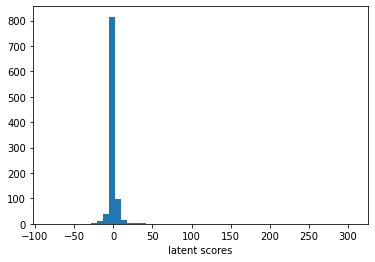

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

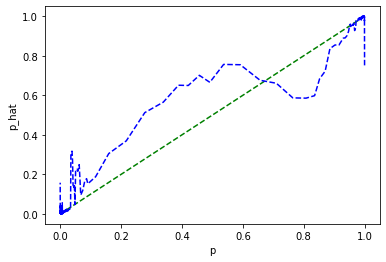

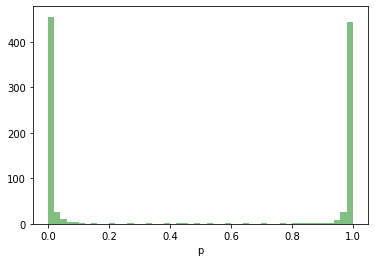

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

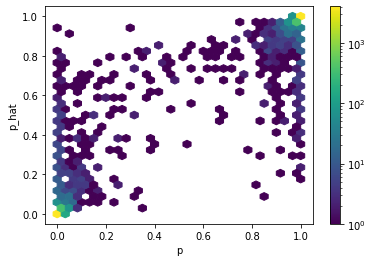

In [10]:
n = 1
s = 100

#p = model.model(x_val[:10000,:])[0][:].numpy()[:,0]
p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

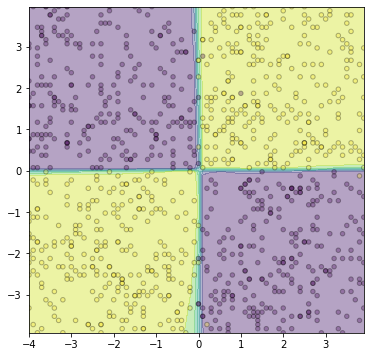

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z[:,0].reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "HLADropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense_72 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_73 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_74 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0

In [13]:
champion_params

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.06967077404260635, 'epoch': 6},
 'best_auc': {'auc': 0.9947949647903442, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.9801999926567078, 'epoch': 6}}

In [15]:
## mcdropout 
##champion_params
{'learning_rate': 0.0084,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.07201100885868073, 'epoch': 6},
 'best_auc': {'auc': 0.9951503872871399, 'epoch': 5},
 'best_accuracy': {'accuracy': 0.9778000116348267, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7fbf2d5acc70>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.15085303783416748, 'epoch': 119},
  'best_auc': {'auc': 0.9918428063392639, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9642500281333923, 'epoch': 119}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.13421103358268738, 'epoch': 119},
  'best_auc': {'auc': 0.9924982786178589, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9686999917030334, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11012635380029678, 'epoch': 119},
  'best_auc': {'auc': 0.9934784173965454, 'epoch': 118},
  'best_accuracy': {'accuracy': 0.9753000140190125, 'epoch': 119}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.11375528573989868, 'epoch': 249},
  'best_auc': {'auc': 0.9940301179885864, 'epoch': 249},
 

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25